In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from IPython.display import display, HTML
from scipy.stats import rankdata
from Orange.evaluation import compute_CD, graph_ranks

sns.set_style("ticks", {
    'axes.grid': True,
    'grid.color': '.5'})
sns.set_context("paper")
# sns.set_palette("crest")
# sns.color_palette("muted")
# sns.color_palette("crest", as_cmap=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
EVALMETRIC = 'roc_auc'

In [3]:
df = pd.read_csv("results_df/undersampling_exp8.csv", index_col=0)
df.loc[df.parameters.str.contains(pat="randomize_A': 0.0"), 'undersampling_method'] = 'hypper_pure'
df.head(3)

,dataset,undersampling_method,eval_algorithm,parameters,accuracy_val,balanced_accuracy_val,roc_auc_val,average_precision_val,precision_val,recall_val,f1_val,accuracy_test,balanced_accuracy_test,roc_auc_test,average_precision_test,precision_test,recall_test,f1_test
0,read_german_data,hypper_pure,lr,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.65,0.726091,0.843035,0.933333,0.929061,0.567568,0.705882,0.65,0.706328,0.742870,0.897436,0.836929,0.530303,0.666667
1,read_german_data,hypper_pure,catboost,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.56,0.665281,0.809771,0.916667,0.909406,0.445946,0.600000,0.62,0.690731,0.778075,0.911765,0.874429,0.469697,0.620000
2,read_german_data,hypper_pure,lightgbm,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.57,0.672037,0.781185,0.918919,0.895000,0.459459,0.612613,0.64,0.713012,0.752674,0.941176,0.860993,0.484848,0.640000


In [4]:
print(f"Undersampling methods: {df['undersampling_method'].unique().tolist()}")
print(f"Datasets: {df['dataset'].unique().tolist()}")
print(f"Evaluation models: {df['eval_algorithm'].unique().tolist()}")
# print(f"Parameters sets: {df['parameters'].unique().tolist()}")

Undersampling methods: ['hypper_pure', 'hypper', 'without_undersampling', 'random_undersampling', 'tomek_links', 'edited_nearest_neighbours', 'near_miss']
Datasets: ['read_german_data', 'read_spect_heart', 'read_banking', 'read_hr', 'read_criteo']
Evaluation models: ['lr', 'catboost', 'lightgbm']


In [5]:
# Select best hypper params validation data
tuned_methods = ['hypper', 'hypper_pure', 'near_miss']
grouping_key = ['undersampling_method','dataset','eval_algorithm','parameters']
df_test = df[df.undersampling_method.isin(tuned_methods)]

df_test = df_test.groupby(grouping_key).mean()
metric = [EVALMETRIC+'_val', EVALMETRIC+'_test']
df_test = df_test[metric].sort_values(by=EVALMETRIC+'_val', ascending=False)
df_test = df_test.groupby(grouping_key[:-1]).head(1).reset_index().set_index(grouping_key).sort_index()
best_params = list(df_test.index)
print(len(best_params))
best_params[:2]

45


[('hypper',
  'read_banking',
  'catboost',
  "{'majority_left_threshold': 0.5, 'method': 'hypper', 'randomize_A': 40.0, 'version': 5, 'weighting_history': True, 'weighting_iteration': 3, 'weighting_normalization_strategy': 'l2'}"),
 ('hypper',
  'read_banking',
  'lightgbm',
  "{'majority_left_threshold': 0.5, 'method': 'hypper', 'randomize_A': 40.0, 'version': 1, 'weighting_history': False, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'l1'}")]

In [6]:
print(df.shape)
df_best = deepcopy(df)
df_best = df_best.set_index(grouping_key)
df_best = df_best[
    (~df_best.index.isin(tuned_methods, level='undersampling_method')) |
    (df_best.index.isin(best_params))
].sort_index().reset_index()
df_best.shape

(22050, 18)


(525, 18)

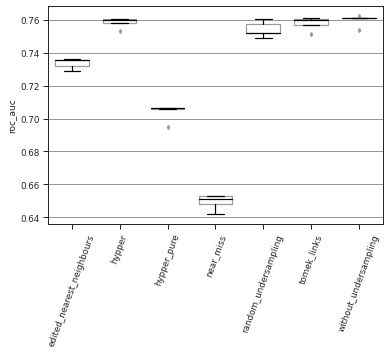

In [7]:
DATASET = 'read_criteo'
EVALALG = 'catboost'

df_plot = df_best[df_best.dataset == DATASET]
df_plot = df_plot[df_plot.eval_algorithm == EVALALG]

f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_plot, x='undersampling_method', y=EVALMETRIC+'_test', ax=ax, color='white', width=.7, fliersize=3)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
plt.xticks(rotation=70)
ax.set_ylabel(EVALMETRIC, fontsize=9)
ax.set_xlabel(None, fontsize=6, weight='bold')
# ax.set_xticklabels(['Without\nundersampling', 'Hypper', 'Tomek\nLinks', 'Random', 'ENN', 'Near-Miss'])
f.savefig(f'results_plots/under_criteo_{EVALMETRIC}.pdf')
plt.show()

Undersampling methods: ['edited_nearest_neighbours', 'hypper', 'hypper_pure', 'near_miss', 'random_undersampling', 'tomek_links', 'without_undersampling']
Shape: (175, 18)
edited_nearest_neighbours average rank: 4.2
hypper average rank: 2.68
hypper_pure average rank: 4.98
near_miss average rank: 6.84
random_undersampling average rank: 4.06
tomek_links average rank: 3.14
without_undersampling average rank: 2.1


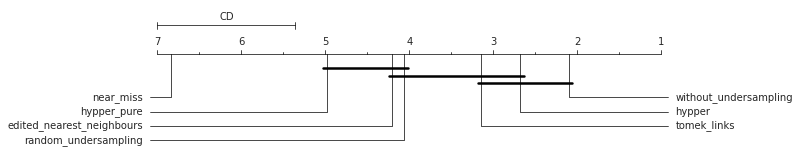

In [8]:
# Friedman test - https://edisciplinas.usp.br/pluginfile.php/4129451/mod_resource/content/1/model_selection_evaluation.pdf
df_eval_metric = df_best[df_best.eval_algorithm == EVALALG].set_index(grouping_key).sort_index().reset_index()
u_methods = df_eval_metric['undersampling_method'].unique().tolist()
datasets = df_eval_metric['dataset'].unique().tolist()
kfolds = 5
print(f"Undersampling methods: {u_methods}")
print(f"Shape: {df_eval_metric.shape}")

df_eval_metric['experiment_num'] = pd.Series(list(range(1,kfolds+1))*len(u_methods)*len(datasets))

# display(df_eval_metric[grouping_key+['experiment_num']+[EVALMETRIC+'_test']].head(50))

performance_array = df_eval_metric.groupby(['dataset', 'experiment_num'])[EVALMETRIC+'_test'].apply(np.array)
# performance_array
ranks = np.array([rankdata(-p) for p in performance_array])
# print(ranks[:5])
average_ranks = np.mean(ranks, axis=0)
# print(average_ranks)
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(u_methods, average_ranks)))

cd = compute_CD(average_ranks,
                n=len(datasets)*kfolds,
                alpha='0.1',
                test='nemenyi')
# This method generates the plot.
graph_ranks(average_ranks,
            names=u_methods,
            cd=cd,
            width=10,
            textspace=1.5,
            reverse=True)
plt.savefig('results_plots/under_friedman.pdf')
plt.show()